# Look at Tract 4431 in Weekly 32

### This is a run of tract 4431 in the DC2 repo with the standad DRP.yaml, steps 1-5, with w_2021_32.
### Please note that this is a very large dataset and you will want to examine it with at least a "large" notebook server on RSP. Some cells may require even greater resources to execute; those are commented by default.

In [1]:
import os
import numpy as np

import scipy
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
import lsst.afw.display as afw_display
import lsst.geom
afwDisplay.setDefaultBackend('matplotlib')
import matplotlib.ticker as plticker
import lsst.afw.cameraGeom.testUtils as testUtils
import lsst.afw.cameraGeom as cameraGeom
from lsst.obs.hsc import HscMapper as mapper
import lsst.daf.butler as dafButler
from skimage.filters import gaussian
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from operator import itemgetter
from itertools import groupby

import astropy.units as u
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)
import astropy.coordinates as coord
import pyarrow.parquet as pq
import lsst.daf.butler as dafButler

In [2]:
truthparquet = '/project/shared/DC2/truth_parquet/truth_tract4431.parquet'

In [3]:
if os.path.exists(truthparquet):
    print(truthparquet + ' exists.')
    try:
        truth = pq.read_pandas(truthparquet).to_pandas()
    except:
        print('This is not working.')
else:
    print('Cannot find' + truthparquet)

/project/shared/DC2/truth_parquet/truth_tract4431.parquet exists.


In [4]:
len(truth)

4817461

In [5]:
truth.head()

,id,host_galaxy,ra,dec,redshift,is_variable,is_pointsource,flux_u,flux_g,flux_r,...,patch,truth_type,cosmodc2_hp,cosmodc2_id,mag_r,match_objectId,match_sep,is_good_match,is_nearest_neighbor,is_unique_truth_entry
0,5002139513,-1,56.498354,-32.727155,1.005462,0,0,137.202881,126.404335,147.231842,...,"0,0",1,9428,5002139513,25.979996,19487744090703406,0.078481,True,True,True
1,5002508207,-1,56.517981,-32.726763,1.016374,0,0,8.663668,24.991816,96.257736,...,"0,0",1,9428,5002508207,26.441412,19487744090703425,0.089966,True,True,True
2,5000205603,-1,56.492242,-32.726853,0.393021,0,0,11.472342,32.223240,93.331459,...,"0,0",1,9428,5000205603,26.474930,19487744090703432,0.065758,True,True,True
3,5002154921,-1,56.483952,-32.726708,1.006463,0,0,498.773285,445.314758,505.875549,...,"0,0",1,9428,5002154921,24.639891,19487744090703433,0.062292,True,True,True
4,5000066351,-1,56.515231,-32.726446,0.254334,0,0,32.451309,150.253571,472.295349,...,"0,0",1,9428,5000066351,24.714466,19487744090703436,0.022272,True,True,True


In [6]:
collection = 'u/kherner/2.2i/runs/test20210807-tract4431-w32-step5'
# Needed so I can steal Eric's code
COLLECTION = collection
repo = '/repo/dc2'
butler = dafButler.Butler(repo, collections=collection)

In [7]:
dataIds =  butler.registry.queryDataIds(['band', 'instrument', 'detector', 'physical_filter', 'visit_system', 'visit'] , datasets="goodSeeingDiff_diaSrcTable", 
                                       collections=COLLECTION, where="instrument='LSSTCam-imSim' and tract=4431")

In [8]:
# debugging
#for x in dataIds:
    # print(x['band'])
#    if x['band'] != 'y':
#        print(x['detector'],x['visit'],x['band'], x['physical_filter'])
#print(dataIds.loc[dataIds['band']=='g'])

### The following cell can easily take 15 minutes or more to run.

In [9]:
tables = []
for dataId in dataIds:
    tables.append(butler.get('goodSeeingDiff_diaSrcTable', dataId=dataId))

df = pd.concat(tables)

### Various diagnostics 

In [10]:
len(df)

2310652

In [11]:
truth.loc[~truth['is_unique_truth_entry'],'id']

5319       5001049475
5322       5006823914
5392       5008265881
5428       5000351169
5674       5013992548
              ...    
1143734    4125143411
1143764    4064417121
1143839    3315580198
1143894    4127200025
1143992    3329845611
Name: id, Length: 7275, dtype: object

In [12]:
truth.loc[(truth.is_variable == True) & (truth.is_pointsource == False) ]

,id,host_galaxy,ra,dec,redshift,is_variable,is_pointsource,flux_u,flux_g,flux_r,...,patch,truth_type,cosmodc2_hp,cosmodc2_id,mag_r,match_objectId,match_sep,is_good_match,is_nearest_neighbor,is_unique_truth_entry


In [13]:
truth.loc[(truth.is_variable == True),'truth_type'].unique()

array([2, 3])

SkyCoords of truth sources

In [14]:
truthsc = coord.SkyCoord(truth.ra,truth.dec,unit='deg')

In [15]:
config = TransformDiaSourceCatalogConfig()
unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')
flag_values = unpacker.unpack(df['flags'], 'flags')
flag_names = list(flag_values.dtype.names)

flags = pd.DataFrame(flag_values, index=df.index)
df = pd.concat([df, flags], axis=1)
print("List of available flags: ", flags.columns)

List of available flags:  Index(['base_PixelFlags_flag', 'base_PixelFlags_flag_offimage',
       'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_interpolated',
       'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_cr',
       'base_PixelFlags_flag_bad', 'base_PixelFlags_flag_suspect',
       'base_PixelFlags_flag_interpolatedCenter',
       'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_crCenter',
       'base_PixelFlags_flag_suspectCenter', 'slot_Centroid_flag',
       'slot_Centroid_pos_flag', 'slot_Centroid_neg_flag', 'slot_ApFlux_flag',
       'slot_ApFlux_flag_apertureTruncated', 'slot_PsfFlux_flag',
       'slot_PsfFlux_flag_noGoodPixels', 'slot_PsfFlux_flag_edge',
       'ip_diffim_forced_PsfFlux_flag',
       'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
       'ip_diffim_forced_PsfFlux_flag_edge', 'slot_Shape_flag',
       'slot_Shape_flag_unweightedBad', 'slot_Shape_flag_unweighted',
       'slot_Shape_flag_shift', 'slot_Shape_flag_maxIter',
       

In [16]:
instrumentDataId = butler.registry.expandDataId(instrument='LSSTCam-imSim')
packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
df['visit'] = df.ccdVisitId.apply(lambda x: packer.unpack(x)['visit'])
df['detector'] = df.ccdVisitId.apply(lambda x: packer.unpack(x)['detector'])

In [17]:
# create some derived columns

pixToArcseconds = 0.2
PIXEL_SCALE = 0.2
SIGMA2FWHM = 2*np.sqrt(2*np.log(2))
traceRadius = np.sqrt(0.5) * np.sqrt(df.ixxPSF + df.iyyPSF)
df['seeing'] = SIGMA2FWHM * traceRadius
myvisit = 993521
mydet = 76
bbox = butler.get('goodSeeingDiff_differenceExp.bbox', visit = myvisit , detector=mydet)
wcs = butler.get('goodSeeingDiff_differenceExp.wcs', visit = myvisit , detector=mydet)
APPROX_CCD_AREA = bbox.getArea()*wcs.getPixelScale().asDegrees()**2

### Plot some images just to say we could

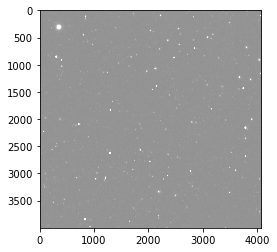

In [18]:
myId = { "skymap": "DC2", "tract": 4431, "instrument":"LSSTCam-imSim"}
calexp = butler.get('calexp',visit = myvisit, detector = mydet, dataId=myId)
calexpNorm = ImageNormalize(calexp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
plt.imshow(calexp.image.array, cmap='gray', norm=calexpNorm)

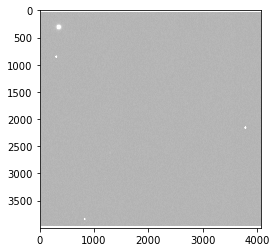

In [19]:
diffim = butler.get('goodSeeingDiff_differenceExp',visit = myvisit, detector = mydet, dataId=myId)
diffimNorm = ImageNormalize(diffim.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
plt.imshow(diffim.image.array, cmap='gray', norm=diffimNorm)

In [20]:
# get Focal Plane Coordinates (is there a faster way to do this?)
camera = butler.get('camera', instrument='LSSTCam-imSim')

def ccd2focalPlane(x, y, ccd):
    cc = int(ccd)
    det = camera[cc]
    point = det.transform(lsst.geom.Point2D(x, y), cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
    return point[0], point[1]

vecCcd2FP =  np.vectorize(ccd2focalPlane)
focal_plane = vecCcd2FP(df['x'].values.astype(float), df['y'].values.astype(float), df['detector'].values.astype(int))
df['xFP'] = focal_plane[0]
df['yFP'] = focal_plane[1]

In [21]:
pixelFlagNames = [
       'base_PixelFlags_flag_offimage',
       'base_PixelFlags_flag_edge',
       'base_PixelFlags_flag_interpolated',
       'base_PixelFlags_flag_saturated',
       'base_PixelFlags_flag_cr',
       'base_PixelFlags_flag_bad',
       'base_PixelFlags_flag_suspect',
       'base_PixelFlags_flag_interpolatedCenter',
       'base_PixelFlags_flag_saturatedCenter',
       'base_PixelFlags_flag_crCenter',
       'base_PixelFlags_flag_suspectCenter']

centroidFlagNames = [
       'slot_Centroid_flag',
       'slot_Centroid_pos_flag',
       'slot_Centroid_neg_flag',]
    
fluxFlagNames = [
       'slot_ApFlux_flag',
       'slot_ApFlux_flag_apertureTruncated',
       'slot_PsfFlux_flag',
       'slot_PsfFlux_flag_noGoodPixels',
       'slot_PsfFlux_flag_edge',
       'ip_diffim_forced_PsfFlux_flag',
       'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
       'ip_diffim_forced_PsfFlux_flag_edge']

shapeFlagNames = [
       'slot_Shape_flag',
       'slot_Shape_flag_unweightedBad',
       'slot_Shape_flag_unweighted',
       'slot_Shape_flag_shift',
       'slot_Shape_flag_maxIter',
       'slot_Shape_flag_psf']

### Plot positions of all diaSources

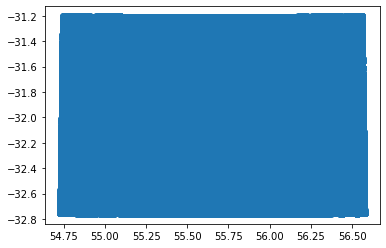

In [22]:
plt.scatter(df.ra,df.decl)

In [23]:
diaSourcesc = coord.SkyCoord(df.ra,df.decl,unit='deg')

### diaSource locations by band

In [24]:
dfb = {}
for myband in [ 'g', 'r', 'i', 'z', 'y', 'u']:
    dfb[myband] = df.loc[df['filterName']==myband]
    print('Number of %s-band sources: %d' % (myband, len(dfb[myband])))

Number of g-band sources: 395637
Number of r-band sources: 742570
Number of i-band sources: 649551
Number of z-band sources: 257625
Number of y-band sources: 158418
Number of u-band sources: 106851


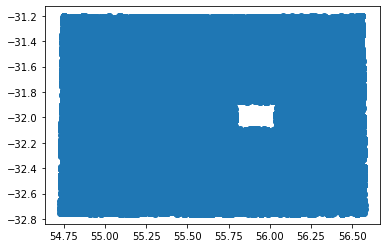

In [25]:
plt.scatter(dfb['g'].ra,dfb['g'].decl)

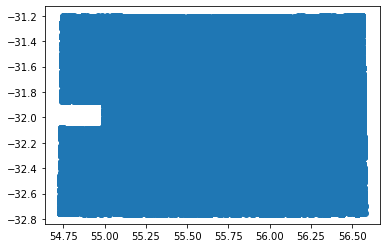

In [26]:
plt.scatter(dfb['r'].ra,dfb['r'].decl)

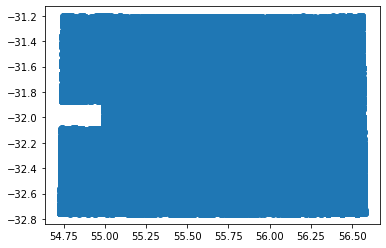

In [27]:
plt.scatter(dfb['i'].ra,dfb['i'].decl)

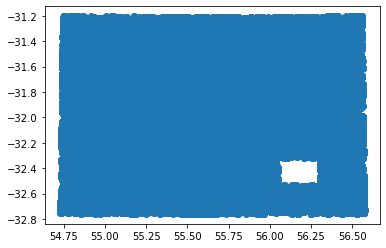

In [28]:
plt.scatter(dfb['z'].ra,dfb['z'].decl)

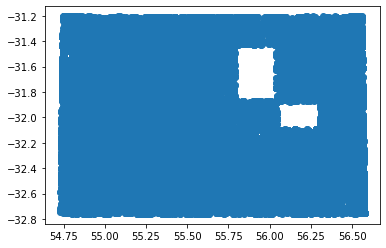

In [29]:
plt.scatter(dfb['y'].ra,dfb['y'].decl)

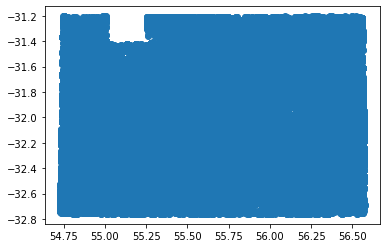

In [30]:
plt.scatter(dfb['u'].ra,dfb['u'].decl)

We are done with these and we don't use them again, so reset the dfb to keep the memory usage down.

In [31]:
dfb = {}

## DIASource associations

In [32]:
dataIds =  butler.registry.queryDataIds(['skymap','tract','patch'] , datasets="goodSeeingDiff_assocDiaSrcTable", 
                                       collections=COLLECTION, where="instrument='LSSTCam-imSim' and tract=4431")

In [33]:
# Diagnostic
set([x['tract'] for x in dataIds])

{4431}

In [34]:
tables = []
for dataId in dataIds:
    tables.append(butler.get('goodSeeingDiff_assocDiaSrcTable', dataId=dataId))
if len(tables) > 0:    
    dfass = pd.concat(tables)
    len(dfass)

### Plot DIASource association sky positions

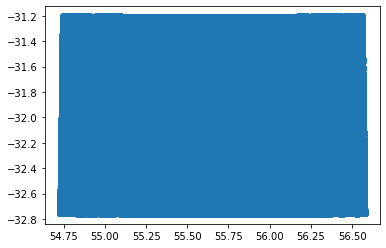

In [35]:
plt.scatter(dfass.ra,dfass.decl)

## DIAObjects

In [36]:
dataIds =  butler.registry.queryDataIds(['skymap','tract','patch'] , datasets="goodSeeingDiff_diaObjTable", 
                                       collections=COLLECTION, where="instrument='LSSTCam-imSim'")

In [37]:
tables = []
for dataId in dataIds:
    tables.append(butler.get('goodSeeingDiff_diaObjTable', dataId=dataId))
if len(tables) > 0:
    dfo = pd.concat(tables)
else:
    print("Cannot concatenate, len(tables) = 0")

In [38]:
len(dfo)

293508

### Sky position of DIAObjects

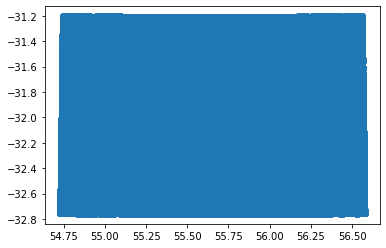

In [39]:
plt.scatter(dfo.ra,dfo.decl)

In [40]:
# Diagnostic
dfo.head()

,diaObjectId,ra,decl,nDiaSources
0,3820072830800756737,54.741889,-31.959340,119
1,3820072830800756738,54.772269,-31.935905,22
2,3820072830800756739,54.825472,-31.899700,85
3,3820072830800756740,54.844584,-31.887058,7
4,3820072830800756741,54.821091,-31.939526,109


## Crossmatch

In [41]:
MATCH_RADIUS_ARCSEC = 1.0

idx, d2d, d3d = diaSourcesc.match_to_catalog_sky(truthsc)

In [42]:
# Diagnostic
truth.iloc[idx]['id']

490857     31107752292
500495     30321357015
485938     31411455447
4487005     4951950387
512794     30321356787
              ...     
1136283    31500278080
1135186    31303571543
1136472    31500277926
1136105     4126506193
2208800     4129760931
Name: id, Length: 2310652, dtype: object

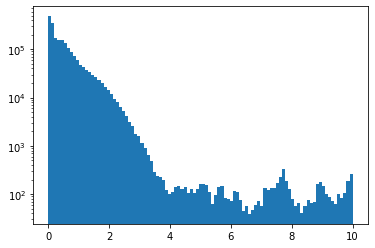

In [43]:
# get back into pandas.  
df['truth_xmatch_dist_arcsec'] = d2d.to_value(u.arcsecond)
# Let's include all the matches, for reference
df['truth_xmatch_id_all'] = pd.Series(truth.iloc[idx]['id'].values, index=df.index)
# now make a column that only has the matches with radius.
df.loc[df['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC, 'truth_xmatch_id'] = df.loc[df['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC, 'truth_xmatch_id_all']
_ = plt.hist(df['truth_xmatch_dist_arcsec'],bins=np.linspace(0,10,100))
plt.gca().set_yscale('log')

In [44]:
dfm = pd.merge(truth,df,left_on='id',right_on='truth_xmatch_id',how='outer')
# Uncomment for debugging
# dfm.columns.to_list()

## Confusion matrix

In [45]:
wmatched = (dfm['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC)

In [46]:
# true positives
wtp = wmatched & (dfm['is_variable'] == 1) # have to use explicit equality since is_variable can be NaN when there is no truth counterpart
ntp = np.sum(wtp)
dfm.loc[wtp,'confusion_label'] = 'True Positive'
print(ntp)

1920592


In [47]:
# true negatives 
wtn = ~wmatched & (dfm['is_variable'] == 0)
ntn = np.sum(wtn)
dfm.loc[wtn,'confusion_label'] = 'True Negative'

print(ntn)

4696051


In [48]:
# false positives (either a match to a non-variable source, or a DIASource with no truth table counterpart)
wfp = (wmatched & (dfm['is_variable'] == 0)) | (dfm['id'].isnull())
nfp = np.sum(wfp)
dfm.loc[wfp,'confusion_label'] = 'False Positive'

print(nfp)

1022770


In [49]:
# false negatives (maybe!  depends how bright the variability is) 
wfn = ~wmatched & (dfm['is_variable'] == 1)
nfn = np.sum(wfn)
dfm.loc[wfn,'confusion_label'] = 'False Negative'

print(nfn)

20822


In [50]:
# now let's put this in sklearn language
y_true = dfm['is_variable'] == 1.0
y_pred = wmatched

In [51]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [52]:
sns.set_context('talk')

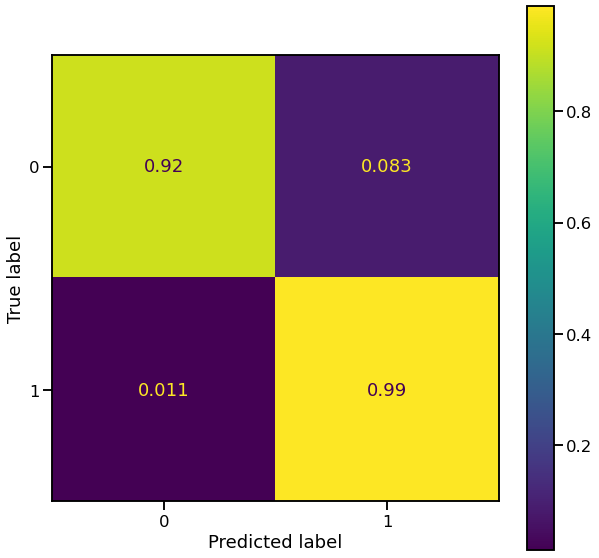

In [53]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cm = confusion_matrix(y_true, y_pred, normalize='true')#, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,
                               #display_labels=clf.classes_)
disp.plot(ax=ax)

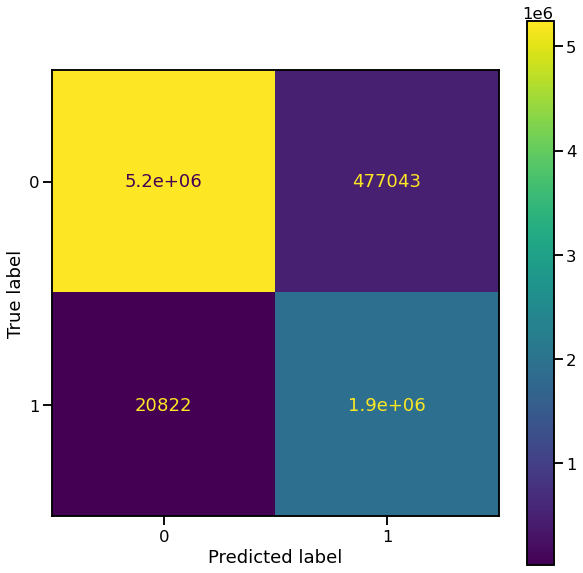

In [54]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cm = confusion_matrix(y_true, y_pred)#, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,
                               #display_labels=clf.classes_)
disp.plot(ax=ax)

In [55]:
completeness = cm[1,1]/np.sum(cm[1,:])
purity = cm[1,1]/np.sum(cm[:,1])
print(completeness, purity)

0.9892748275226201 0.801036020912274


## Plots

Text(0, 0.5, 'Number of Sources')

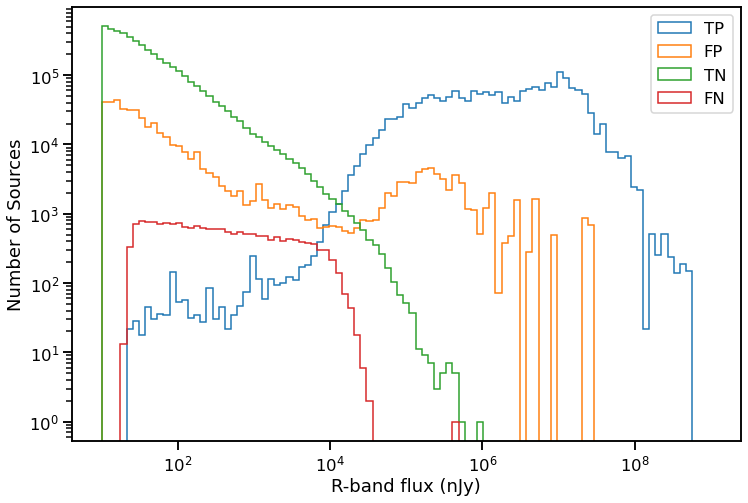

In [56]:
fig = plt.figure(figsize=(12,8))
bins = np.logspace(1,9,100)
_ = plt.hist(dfm.loc[wtp,'flux_r'],bins=bins, label='TP', histtype='step')
_ = plt.hist(dfm.loc[wfp,'flux_r'],bins=bins, label='FP', histtype='step')
_ = plt.hist(dfm.loc[wtn,'flux_r'],bins=bins, label='TN', histtype='step')
_ = plt.hist(dfm.loc[wfn,'flux_r'],bins=bins, label='FN', histtype='step')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.xlabel('R-band flux (nJy)')
plt.ylabel('Number of Sources')

Text(0, 0.5, 'Number of Sources')

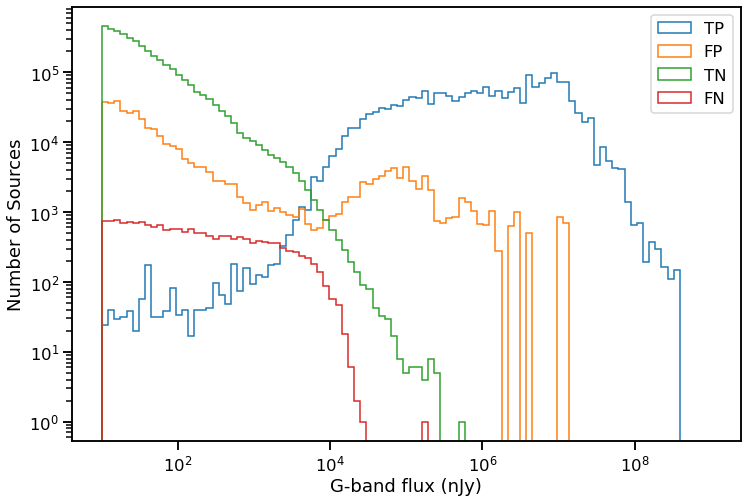

In [57]:
fig = plt.figure(figsize=(12,8))
bins = np.logspace(1,9,100)
_ = plt.hist(dfm.loc[wtp,'flux_g'],bins=bins, label='TP', histtype='step')
_ = plt.hist(dfm.loc[wfp,'flux_g'],bins=bins, label='FP', histtype='step')
_ = plt.hist(dfm.loc[wtn,'flux_g'],bins=bins, label='TN', histtype='step')
_ = plt.hist(dfm.loc[wfn,'flux_g'],bins=bins, label='FN', histtype='step')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.xlabel('G-band flux (nJy)')
plt.ylabel('Number of Sources')

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


Text(0, 0.5, 'Number of Sources')

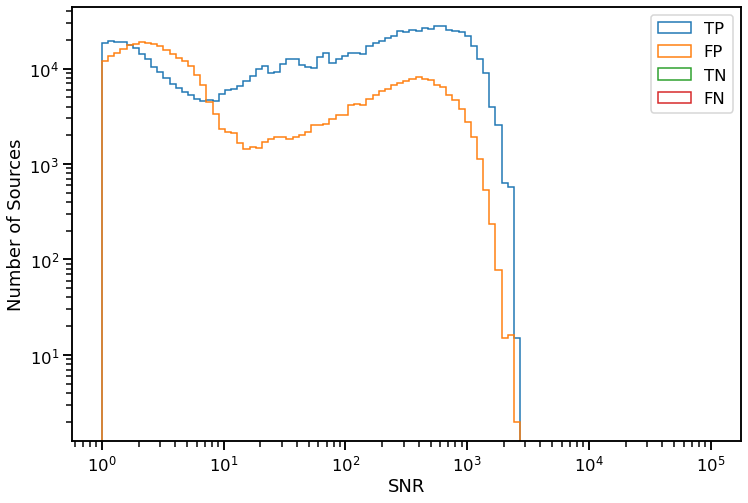

In [58]:
fig = plt.figure(figsize=(12,8))
bins = np.logspace(0,5,100)
_ = plt.hist(dfm.loc[wtp,'snr'],bins=bins, label='TP', histtype='step')
_ = plt.hist(dfm.loc[wfp,'snr'],bins=bins, label='FP', histtype='step')
_ = plt.hist(dfm.loc[wtn,'snr'],bins=bins, label='TN', histtype='step')
_ = plt.hist(dfm.loc[wfn,'snr'],bins=bins, label='FN', histtype='step')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.xlabel('SNR')
plt.ylabel('Number of Sources')

### This next cell is extremely memory-intensive and is thus commented out by default. 
### You will likely need more than 12 GB of available memory to execute it.

In [59]:
#grp = dfm.groupby('confusion_label')
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(grp.agg(np.nanmedian).T)

In [60]:
print(f'{"":<40}\tFP  \tTP')
for col in dfm.columns:
    if 'flag' in col and col != 'flags':
        print(f'{col:<40}\t{dfm.loc[wfp,col].sum()/np.sum(wfp)*100:3.1f}%\t{dfm.loc[wtp,col].sum()/np.sum(wtp)*100:3.1f}%')

                                        	FP  	TP
base_PixelFlags_flag                    	0.0%	0.0%
base_PixelFlags_flag_offimage           	0.0%	0.0%
base_PixelFlags_flag_edge               	24.4%	48.0%
base_PixelFlags_flag_interpolated       	45.0%	51.6%
base_PixelFlags_flag_saturated          	44.9%	55.4%
base_PixelFlags_flag_cr                 	6.3%	6.0%
base_PixelFlags_flag_bad                	0.0%	0.0%
base_PixelFlags_flag_suspect            	0.0%	0.0%
base_PixelFlags_flag_interpolatedCenter 	43.7%	50.3%
base_PixelFlags_flag_saturatedCenter    	44.8%	55.4%
base_PixelFlags_flag_crCenter           	1.8%	1.3%
base_PixelFlags_flag_suspectCenter      	0.0%	0.0%
slot_Centroid_flag                      	0.0%	0.0%
slot_Centroid_pos_flag                  	0.0%	0.0%
slot_Centroid_neg_flag                  	0.0%	0.0%
slot_ApFlux_flag                        	0.0%	0.0%
slot_ApFlux_flag_apertureTruncated      	0.0%	0.0%
slot_PsfFlux_flag                       	4.4%	1.9%
slot_PsfFlux_flag_noGoo

Location of false positives by pixel:

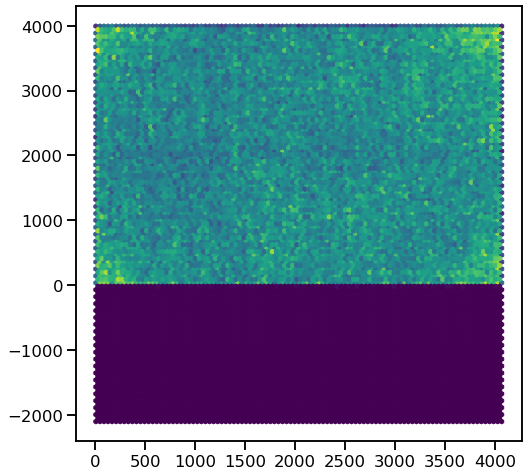

In [61]:
plt.figure(figsize=(8,8))
plt.hexbin(dfm.loc[wfp,'x'],dfm.loc[wfp,'y'])

Location of true positives by pixel.

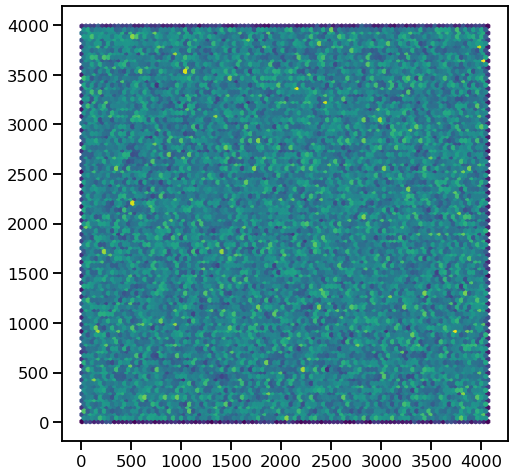

In [62]:
plt.figure(figsize=(8,8))
plt.hexbin(dfm.loc[wtp,'x'],dfm.loc[wtp,'y'])